In [27]:
# import statements
import xarray as xr
from wofs.post.wofs_cbook import calc_mslp, calc_var_at_plev
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [4]:
# function because some of the simulations have a messed-up calendar
def preprocess(ds_in: xr.Dataset) -> xr.Dataset:
    ds_in.XTIME.attrs["units"] = "minutes since 2021-09-01 23:00:00"
    ds_in.XTIME.attrs["description"] = "minutes since 2021-09-01 23:00:00"
    return(ds_in)

def load(var: str, init_time: str, ens_num: int):
    path = "/mnt/drive2/wof-runs/"+init_time+"/"+var+"/wrfwof*.{:02d}".format(ens_num)
    return(xr.open_mfdataset(path,preprocess=preprocess,
                          decode_times=False,combine="nested",
                          concat_dim="Time")
    )
def fix_xtime(ds_in: xr.Dataset,init_time: str) -> xr.Dataset:
    if init_time in ["20", "21", "22", "23"]:
        start_date = "2021-09-01"
    elif init_time in ["00", "01", "02"]:
        start_date = "2021-09-02"
    else:
        raise ValueError("Unexpected init_time provided.")
    ds_in.XTIME.attrs["units"] = "minutes since "+start_date+" "+init_time+":00:00"
    ds_in.XTIME.attrs["description"] = ("minutes since "+start_date+" "+
                                        init_time+":00:00")
    return(xr.decode_cf(ds_in))

In [13]:
T2_21Z = fix_xtime(load("T2","21Z",1),"21").T2.load()
HGT_21Z = fix_xtime(load("HGT","21Z",1),"21").HGT.load()
PSFC = fix_xtime(load("PSFC","21Z",1),"21").PSFC.load()

In [57]:
xr.DataArray?

Init signature:
xr.DataArray(
    data: 'Any' = <NA>,
    coords: 'Sequence[tuple] | Mapping[Any, Any] | None' = None,
    dims: 'Hashable | Sequence[Hashable] | None' = None,
    name: 'Hashable' = None,
    attrs: 'Mapping' = None,
    indexes: 'dict[Hashable, pd.Index]' = None,
    fastpath: 'bool' = False,
)
Docstring:     
N-dimensional array with labeled coordinates and dimensions.

DataArray provides a wrapper around numpy ndarrays that uses
labeled dimensions and coordinates to support metadata aware
operations. The API is similar to that for the pandas Series or
DataFrame, but DataArray objects can have any number of dimensions,
and their contents have fixed data types.

Additional features over raw numpy arrays:

- Apply operations over dimensions by name: ``x.sum('time')``.
- Select or assign values by integer location (like numpy):
  ``x[:10]`` or by label (like pandas): ``x.loc['2014-01-01']`` or
  ``x.sel(time='2014-01-01')``.
- Mathematical operations (e.g., ``x - y``) v

In [58]:
calc_mslp(T2_21Z,HGT_21Z,PSFC)

<xarray.DataArray (Time: 73, south_north: 300, west_east: 300)>
array([[[1004.60046, 1004.9125 , 1004.68066, ..., 1011.84155,
         1011.5216 , 1011.84155],
        [1004.65265, 1004.97534, 1004.9095 , ..., 1011.52155,
         1011.5216 , 1011.84155],
        [1004.7829 , 1005.2521 , 1004.9334 , ..., 1011.52155,
         1011.2016 , 1011.52155],
        ...,
        [1014.2086 , 1015.8452 , 1015.24713, ..., 1009.9016 ,
         1009.51483, 1009.3709 ],
        [1014.2084 , 1015.5418 , 1015.3365 , ..., 1009.73596,
         1009.5449 , 1009.6744 ],
        [1014.8027 , 1015.6255 , 1015.55396, ..., 1009.4509 ,
         1009.38196, 1009.7389 ]],

       [[1004.61475, 1004.927  , 1004.71173, ..., 1011.52155,
         1011.5216 , 1011.84155],
        [1004.65265, 1005.33746, 1004.9555 , ..., 1011.52155,
         1011.5216 , 1011.52155],
        [1004.799  , 1005.28503, 1004.9981 , ..., 1011.52155,
         1011.2016 , 1011.52155],
...
        [1014.84875, 1016.95416, 1016.8919 , ..., 1011.99786,
         1011.90967, 1011.7473 ],
        [1014.8486 , 1016.49884, 1016.947  , ..., 1012.14636,
         1011.9582 , 1012.09314],
        [1015.46454, 1016.7236 , 1016.7997 , ..., 1011.8469 ,
         1011.81195, 1012.1827 ]],

       [[1009.36884, 1010.02875, 1009.8439 , ..., 1011.20154,
         1011.2016 , 1011.52155],
        [1009.4479 , 1009.8421 , 1009.7764 , ..., 1011.20154,
         1011.2016 , 1011.52155],
        [1009.7158 , 1010.2154 , 1009.8539 , ..., 1011.20154,
         1011.2016 , 1011.52155],
        ...,
        [1014.84875, 1016.95416, 1016.8919 , ..., 1011.99786,
         1011.9124 , 1011.74976],
        [1014.8486 , 1016.49884, 1016.947  , ..., 1012.14636,
         1011.9582 , 1012.09314],
        [1015.46454, 1016.7236 , 1016.7997 , ..., 1011.8469 ,
         1011.81537, 1012.1869 ]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 36.37 36.37 ... 44.67 44.67
    XLONG    (Time, south_north, west_east) float32 -80.56 -80.52 ... -69.55
    XTIME    (Time) datetime64[ns] 2021-09-01T21:00:00 ... 2021-09-02T03:00:00
Dimensions without coordinates: Time, south_north, west_east

In [31]:
T = fix_xtime(load("T","21Z",1),"21").T.load().isel(Time=0).squeeze()
P = fix_xtime(load("P","21Z",1),"21").P.load().isel(Time=0).squeeze()
PB = fix_xtime(load("PB","21Z",1),"21").PB.load().isel(Time=0).squeeze()

In [55]:
T.attrs

{'FieldType': 104,
 'MemoryOrder': 'XYZ',
 'description': 'perturbation potential temperature (theta-t0)',
 'units': 'K',
 'stagger': '',
 'number_of_significant_digits': 3}

In [52]:
calc_var_at_plev(np.array(T),np.array(PB),np.array(P),850)

array([[ 3.5970378,  3.4274411,  3.2960846, ...,  4.503478 ,  4.5793624,
         4.634159 ],
       [ 3.41549  ,  3.3139377,  3.2457643, ...,  4.723251 ,  4.827321 ,
         4.861457 ],
       [ 3.422336 ,  3.38622  ,  3.2985692, ...,  4.903097 ,  5.1536255,
         5.0215874],
       ...,
       [-5.3160067, -5.5190964, -5.455457 , ..., -2.4589741, -2.436269 ,
        -2.4119332],
       [-5.175051 , -5.398464 , -5.401823 , ..., -2.4239619, -2.4558258,
        -2.4649177],
       [-5.2837033, -5.4245477, -5.385287 , ..., -2.4455025, -2.473708 ,
        -2.5202842]], dtype=float32)

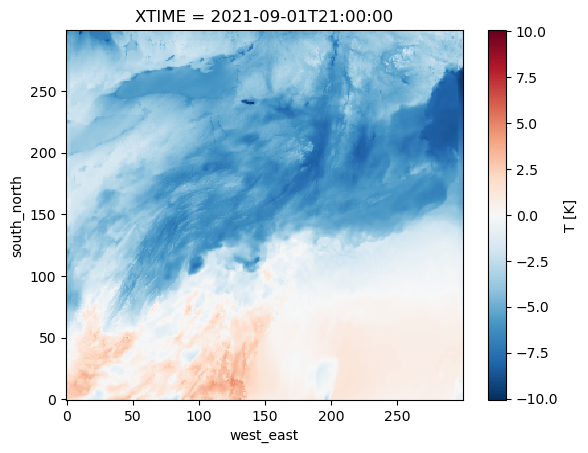

In [54]:
T.isel(bottom_top=0).plot()

In [36]:
pres = P + PB

In [42]:
np.argmax((pres < 85000),axis=0)

ValueError: dimensions ('bottom_top', 'south_north', 'west_east') must have the same length as the number of data dimensions, ndim=2

In [46]:
p_top = (pres<85000).argmax(dim="bottom_top")
p_bot = (p_top - 1)
p_bot = xr.where(p_bot<0,0,p_bot)

AttributeError: module 'xarray' has no attribute 'reshape'